In [1]:
from src.data import create_dataset, make_DataLoader, data_visualization

from src.model import Scene_Graph_Model

from src.utils import train_model, test_model, count_parameters, plot_loss, print_relationships

import torch as th

import numpy as np

# Data Generation

`NUM_IMAGES` images of simple geometric shapes (rectangles, circles and triangles) are going to be generated using matplotlib.

A random number of shapes (maximum in `MAX_OBJECTS`) will be placed on a `IMAGE_SIZE`x`IMAGE_SIZE` image with a white background, with random colors and positions.

The images and the corresponding annotations (class labels and bounding boxes) will be th.saved.

## Image generation

In [2]:
#Constants
TRAIN_IMAGE_DIR = 'train_images'
TEST_IMAGE_DIR = 'test_images'
DATA_DIR = 'data'
TRAIN_ANNOTATIONS = 'train_data.tensor'
TEST_ANNOTATIONS = 'test_data.tensor'
IMAGE_SIZE = 128
SHAPE_SIZE_MIN = 15
SHAPE_SIZE_MAX = 35
NUM_TRAIN_IMAGES = 10000
NUM_TEST_IMAGES = 2000
MAX_OBJECTS = 4

In [61]:
# Generate images
train_data, train_relationships = create_dataset(NUM_TRAIN_IMAGES, IMAGE_SIZE, TRAIN_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=True, origami=False)

# save annotations
th.save(train_data, DATA_DIR + '/' + TRAIN_ANNOTATIONS)
th.save(train_relationships, DATA_DIR + '/train_relationships.tensor')

The directory train_images already exists. Do you want to delete it? [y/n]


 y


Creating image dataset, size: 17.14 MB: 100%|████████████████████████████████████| 10000/10000 [08:13<00:00, 20.28it/s]


In [3]:
# Generate images
test_data, test_relationships = create_dataset(NUM_TEST_IMAGES, IMAGE_SIZE, TEST_IMAGE_DIR, MAX_OBJECTS, SHAPE_SIZE_MIN, SHAPE_SIZE_MAX, geometric=False, rotate=True, origami=False)

# save annotations
th.save(test_data, DATA_DIR + '/' + TEST_ANNOTATIONS)
th.save(test_relationships, DATA_DIR + "/test_relationships.tensor")

The directory test_images already exists. Do you want to delete it? [y/n]


 y


Creating image dataset, size: 4.11 MB: 100%|███████████████████████████████████████| 2000/2000 [06:18<00:00,  5.29it/s]


## Display Data

### Data Visualization

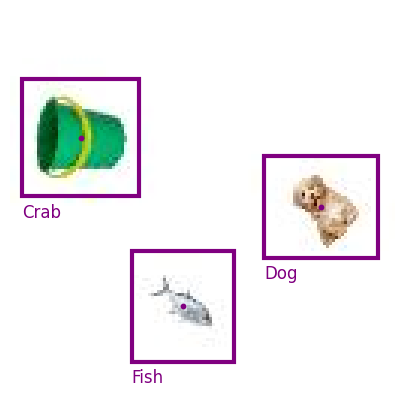

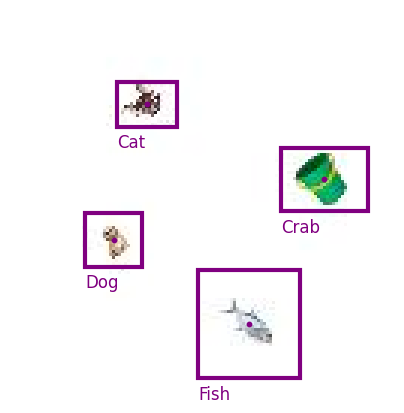

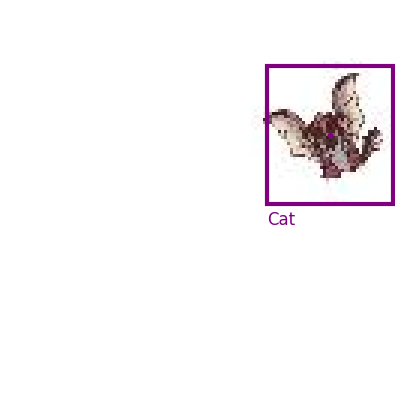

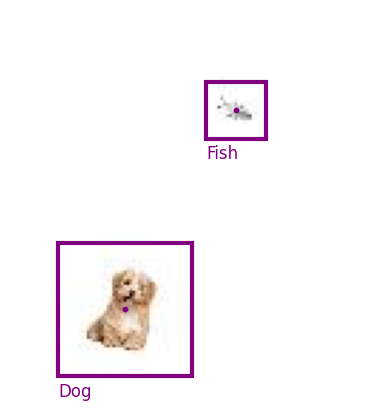

In [5]:
data_visualization(real=True, origami=True)

## DataLoader

### Image loading

In [62]:
make_DataLoader(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR, IMAGE_SIZE, DATA_DIR, TRAIN_ANNOTATIONS, TEST_ANNOTATIONS)

Loading the images in test_images...: 100%|████████████████████████████████████████| 2000/2000 [00:20<00:00, 97.95it/s]


Loading Complete


# Model

In [63]:
train_loader = th.load('./dataloaders/train_loader.tensor')
test_loader = th.load('./dataloaders/test_loader.tensor')

In [11]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

#model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)

# criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :4], y[:, 0, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 1, :4], y[:, 1, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 2, :4], y[:, 2, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 3, :4], y[:, 3, :4]) \
#                             + th.nn.functional.cross_entropy(y_hat[:, 4, :4], y[:, 4, :4]) \
#                             + th.nn.functional.mse_loss(y_hat[:, :, 4:], y[:, :, 4:]) \
#                             + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :5], y[:, 0, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 1, :5], y[:, 1, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 2, :5], y[:, 2, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 3, :5], y[:, 3, :5]) \
                                                   + th.nn.functional.mse_loss(y_hat[:, :, 5:], y[:, :, 5:]) \
                                                   + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

In [23]:
weights = th.load('./models/model_origami_without_rotations.pth')
model.load_state_dict(weights)

<All keys matched successfully>

In [10]:
criterion = lambda y_hat, y, relation_out, relation: th.nn.functional.cross_entropy(y_hat[:, 0, :5], y[:, 0, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 1, :5], y[:, 1, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 2, :5], y[:, 2, :5]) \
                                                   + th.nn.functional.cross_entropy(y_hat[:, 3, :5], y[:, 3, :5]) \
                                                   + th.nn.functional.mse_loss(y_hat[:, :, 5:], y[:, :, 5:]) \
                                                   + th.nn.functional.binary_cross_entropy_with_logits(relation_out, relation)

In [64]:
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
model, train_loss, test_loss = train_model(model, optimizer, criterion, train_loader, test_loader, 100)

Loss 6.8387/21.9839, Acc 0.91/1.00, Relation: 0.96/0.93: 100%|███████████████████████| 100/100 [07:24<00:00,  4.45s/it]


For geometric images: 120 epochs

For origami without rotation: 200 epochs

For origami with rotation: 100 more epochs

For real images without rotation: 200 epochs

For real images with rotation: 200 more epochs

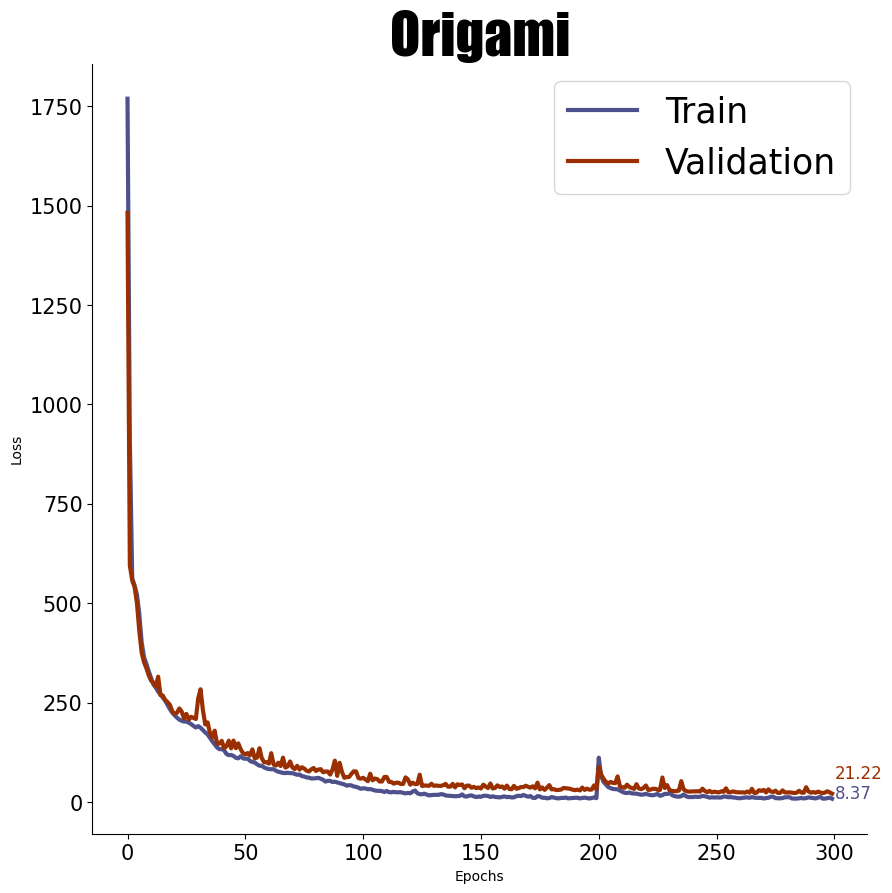

In [28]:
plot_loss(train_loss, test_loss, title = 'Origami')

In [8]:
bho, bho2, bho3 = next(iter(test_loader))

In [22]:
print(bho2[0, :, :5].argmax(1))
bho2[0, :, 5:]

tensor([1, 2, 3, 4])


tensor([[ 34.,  48.,  40.,  38.],
        [ 84.,  51.,  30.,  33.],
        [ 46.,  95.,  48.,  52.],
        [ 96., 106.,  13.,  18.]])

In [83]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   main.ipynb
	modified:   src/data.py
	modified:   src/utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	assets/bucket2.png
	assets/prune.png
	data/
	dataloaders/
	datasets/
	losses/
	models/prova.pth
	src/.ipynb_checkpoints/
	src/__pycache__/
	test_images/
	train_images/

no changes added to commit (use "git add" and/or "git commit -a")


In [5]:
print(model(bho.float().to(device))[0][0, :, :5].argmax(1))
model(bho.float().to(device))[0][0, :, 5:]

NameError: name 'bho' is not defined

In [60]:
# save the model
# os.makedirs('./models', exist_ok=True)
th.save(model.state_dict(), './models/prova.pth')

In [77]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = Scene_Graph_Model(num_boxes=4, num_classes=4, num_relation=6).to(device)
# model = Scene_Graph_Model(num_boxes=5, num_classes=3, num_relation=6).to(device)
# weights = th.load('./models/best_geometric_model.pth')
# weights = th.load('./models/best_origami_model.pth')
weights = th.load('./models/prova.pth')
# weights = th.load('./models/best_realimage_model.pth')
model.load_state_dict(weights)

<All keys matched successfully>

Creating image dataset, size: 0.00 MB: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.92it/s]


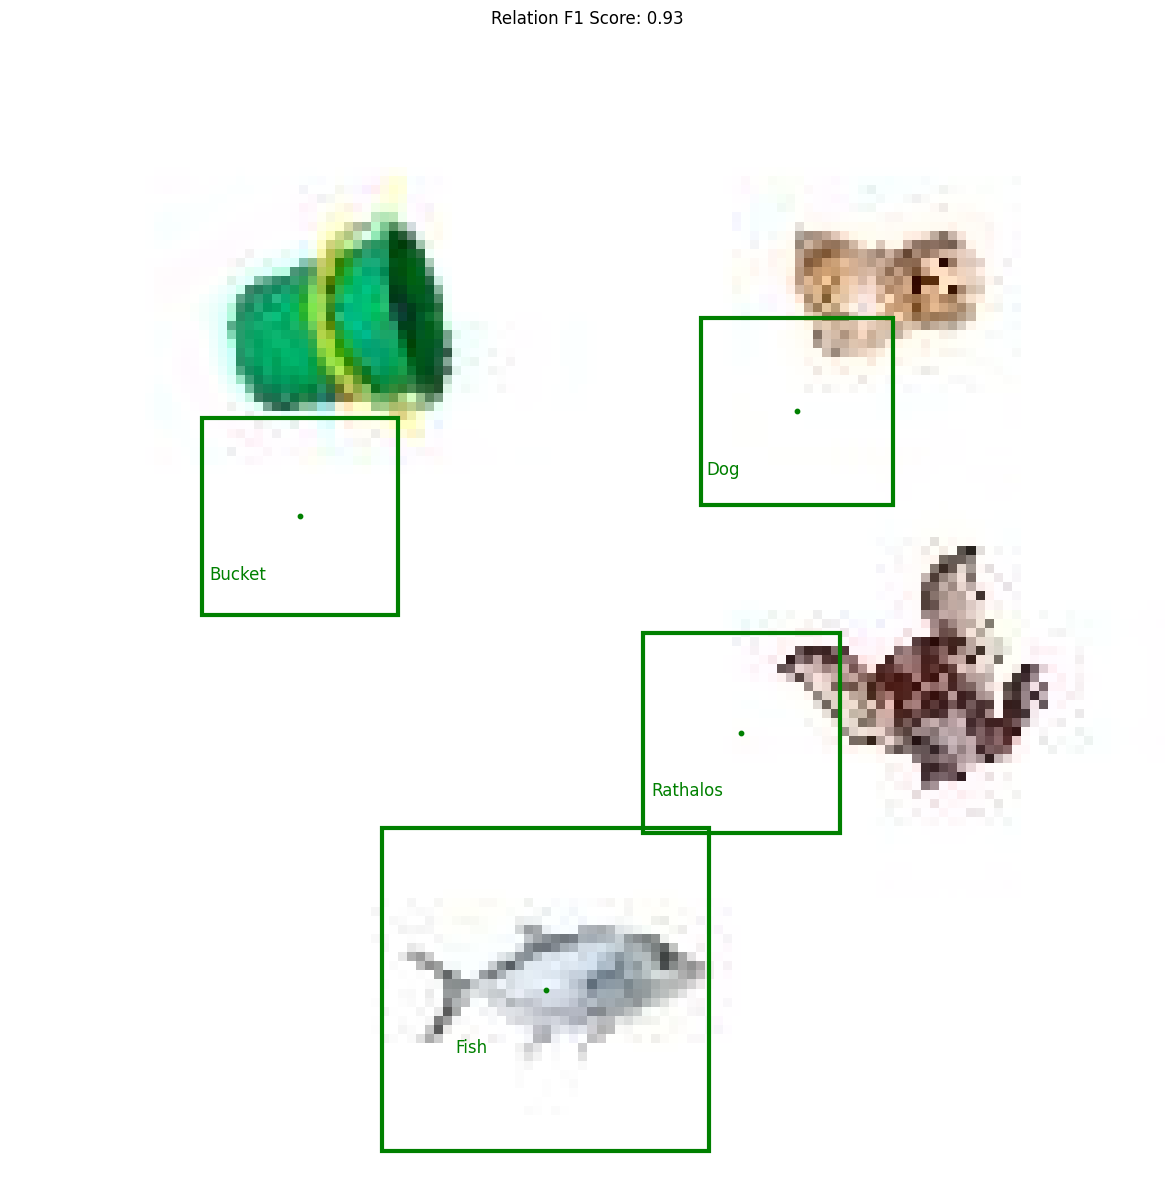

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

<Figure size 1500x1500 with 0 Axes>

In [82]:
test_model(model, device, DATA_DIR, geometric=False, rotate=True, origami=False, SHAPE_SIZE_MIN=15)

In [ ]:
print_relationships((th.sigmoid(out_relation[0]) > 0.5).int(), out)

NameError: name 'out_relation' is not defined

In [ ]:
print_relationships(relation[0], out)